## LSTM Notebook to work in 

In [142]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import random
from tensorflow.keras.losses import Huber

In [143]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
# Configure TensorFlow for deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [144]:
# # Define additional technical indicators // rolling averages for smoother values of target
# def add_technical_indicators(df):
#     df['SMA_10'] = df['Dow_Jones_Target'].rolling(window=10).mean()  # 10-day Simple Moving Average
#     df['SMA_50'] = df['Dow_Jones_Target'].rolling(window=50).mean()  # 50-day Simple Moving Average
#     df['RSI'] = compute_rsi(df['Dow_Jones_Target'], window=14)  # Relative Strength Index (14-day)
#     #RSI is a momentum indicator that measures the speed and change of price movements
#     return df.fillna(method='bfill') 

# # Function to compute RSI (Relative Strength Index)
# def compute_rsi(series, window=14):
#     delta = series.diff() #delta = daily changes between each value
#     gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
#     loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
#     rs = gain / loss
#     return 100 - (100 / (1 + rs)) #to scale in a range of 0 to 100




def add_technical_indicators(df):
    # No additional indicators added here
    return df

In [145]:
def preprocess_data(df, target_column='Dow_Jones_Target', look_back=50):
    # Drop Date and add technical indicators
    df = df.drop(columns=['Date'])
    df = add_technical_indicators(df)

    # Separate scaling for features and target
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Scale features and target separately
    #features = df.drop(columns=[target_column])
    features =df
    target = df[[target_column]]
    scaled_features = feature_scaler.fit_transform(features)
    scaled_target = target_scaler.fit_transform(target)
    
    # Combine scaled features and target back for sequential data 
    # Here, we include `scaled_target` within `scaled_features` directly as part of X.
    scaled_data = np.hstack([scaled_features, scaled_target])

    # Creating sequences of look_back days for LSTM input
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i - look_back:i, :])  # look_back days of data as input, now including `Dow_Jones_Target`
        y.append(scaled_data[i, -1])  # target Dow Jones value at time `i`
    
    X, y = np.array(X), np.array(y).reshape(-1, 1)  # Reshape y to (N, 1) format
    
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
    
    return X_train, X_val, X_test, y_train, y_val, y_test, feature_scaler, target_scaler


In [146]:
# Simple LSTM model
def build_simplified_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(175, return_sequences=False, input_shape=input_shape)) #change units
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))
    return model


In [147]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [148]:
# Load and preprocess data
econ_data = pd.read_csv('main_data.csv')
df = econ_data[['Date', 'Dow_Jones_Target']]

### Non-recursive Prediction

In [149]:
X_train, X_val, X_test, y_train, y_val, y_test, feature_scaler, target_scaler = preprocess_data(df)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((2394, 50, 2), (513, 50, 2), (514, 50, 2), (2394, 1), (513, 1), (514, 1))

In [150]:
# X_train, X_val, X_test, y_train, y_val, y_test, feature_scaler, target_scaler = preprocess_data(df)
# print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_simplified_lstm_model(input_shape) #build_complex_lstm_model , build_simplified_lstm_model , optimized_lstm_model
model.summary()
#model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error') #huber_loss
#model.compile(optimizer=Adam(learning_rate=0.0005), loss=Huber())

from tensorflow.keras.callbacks import LearningRateScheduler
import math

# Define exponential decay function
def lr_scheduler(epoch, lr):
    initial_lr = 0.0005
    k = 0.1  # Decay rate
    new_lr = initial_lr * math.exp(-k * epoch)
    return max(new_lr, 0.00001)  # Ensure the LR doesn't drop below a threshold

lr_schedule = LearningRateScheduler(lr_scheduler, verbose=1)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

/Users/maxquarder/.pyenv/versions/3.11.6/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 175)            │       124,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 175)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           176 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,776 (487.41 KB)

 Trainable params: 124,776 (487.41 KB)

 Non-trainable params: 0 (0.00 B)

In [151]:
# Train the LSTM model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=16, #try 8, 16, 32, 64
    shuffle=False,  # Prevent shuffling of batches for consistent order --> deterministic!!
    #callbacks=[early_stopping, reduce_lr],
    callbacks=[early_stopping, lr_schedule],
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0005.
Epoch 1/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0011 - val_loss: 6.7433e-04 - learning_rate: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00045241870901797975.
Epoch 2/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0013 - val_loss: 8.5065e-04 - learning_rate: 4.5242e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0004093653765389909.
Epoch 3/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - val_loss: 0.0022 - learning_rate: 4.0937e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00037040911034085894.
Epoch 4/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - val_loss: 0.0014 - learning_rate: 3.7041e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0003351600230178197.
Epoch 5/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0010 - val_loss: 3.8106e-04 - learning_rate: 3.3516e-04

Epoch 6: LearningRat

In [152]:
# Make predictions on the test set with LSTM
predictions = model.predict(X_test)
predictions_original_scale = target_scaler.inverse_transform(predictions)
y_test_original_scale = target_scaler.inverse_transform(y_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [153]:
# Calculate Evaluation Metrics
mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_original_scale, predictions_original_scale)
r2 = r2_score(y_test_original_scale, predictions_original_scale)
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAPE: 0.5840196215635279%
MAE: 201.5251100437744
MSE: 75081.04512175727
RMSE: 274.0092062719011
R2: 0.9817422102428002


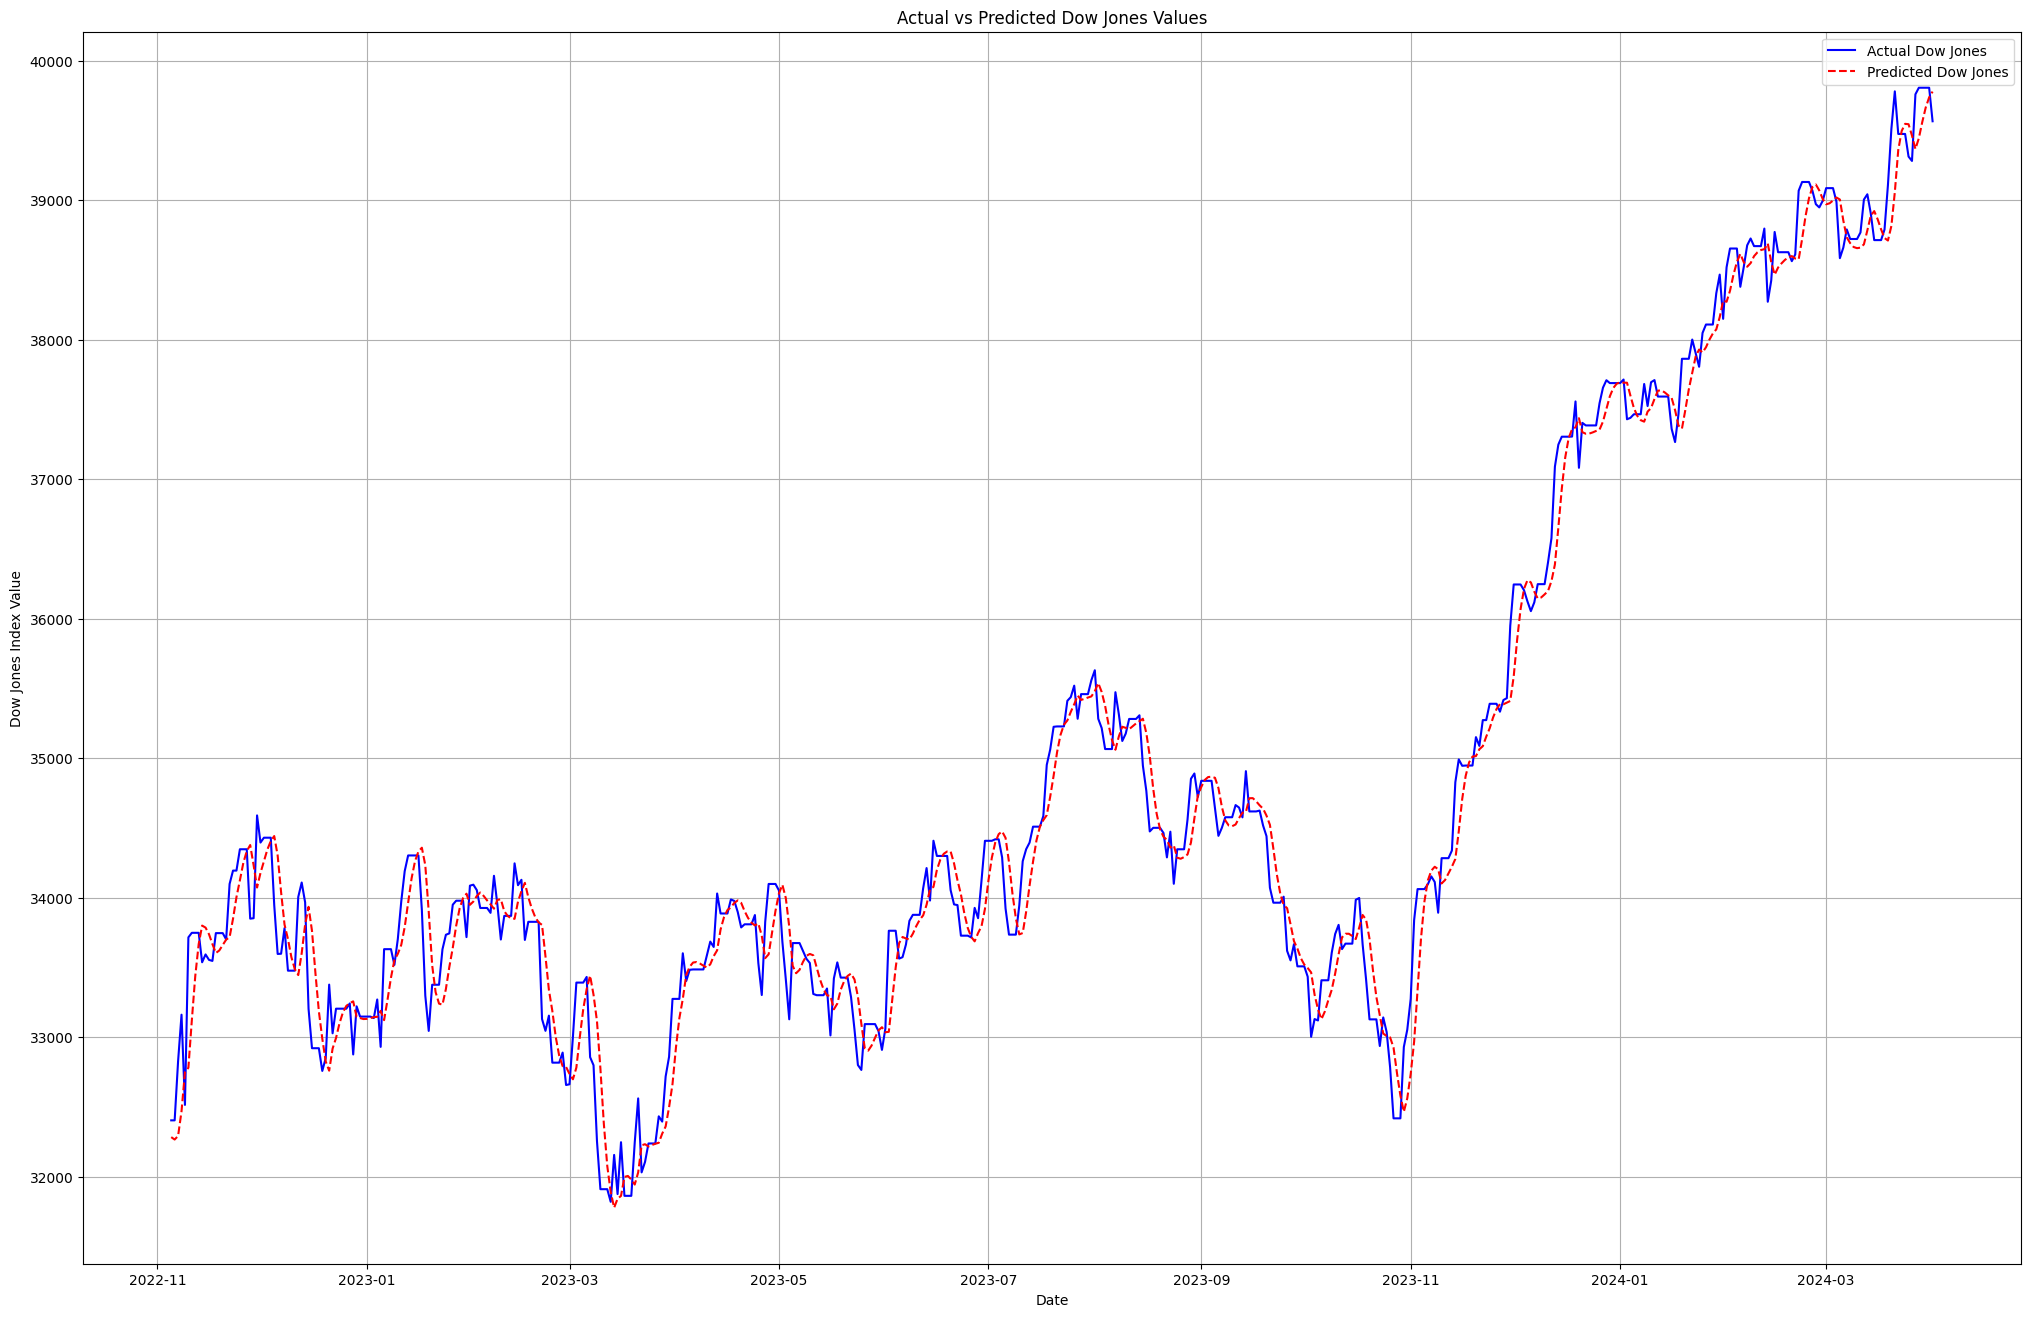

In [154]:
import matplotlib.dates as mdates

# Assuming 'econ_data' includes the original 'Date' column
test_dates = pd.to_datetime(econ_data['Date'].iloc[len(econ_data) - len(y_test):].reset_index(drop=True))

# Convert y_test_original_scale and predictions_original_scale to DataFrames (if not already)
y_test_original_scale_df = pd.DataFrame(y_test_original_scale, columns=["Actual"])
predictions_original_scale_df = pd.DataFrame(predictions_original_scale, columns=["Predicted"])

# Assign the test_dates as the index for both DataFrames
y_test_original_scale_df["Date"] = test_dates
predictions_original_scale_df["Date"] = test_dates

# Plotting with corresponding dates on the x-axis (months and years only)
plt.figure(figsize=(25, 16))
plt.plot(y_test_original_scale_df["Date"], y_test_original_scale_df["Actual"], label="Actual Dow Jones", linestyle='-', color='blue')
plt.plot(predictions_original_scale_df["Date"], predictions_original_scale_df["Predicted"], label="Predicted Dow Jones", linestyle='--', color='red')
plt.xlabel("Date")
plt.ylabel("Dow Jones Index Value")
plt.title("Actual vs Predicted Dow Jones Values")

# Format the x-axis to display only months and years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Example: "Jan 2024"
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Tick every month

#plt.xticks(rotation=45)  # Rotate dates for better readability
plt.legend()
plt.grid()
plt.savefig('LSTM_Loop1_Simplemodel_actual_vs_predicted_with_month_year.pdf', format='pdf')
plt.show()


In [155]:
# # Plot actual vs predicted values
# plt.figure(figsize=(12, 6))
# plt.plot( y_test_original_scale.index, y_test_original_scale, label="Actual Dow Jones", linestyle='-', color='blue')
# plt.plot(predictions_original_scale.index, predictions_original_scale, label="Predicted Dow Jones", linestyle='--', color='red')
# plt.xlabel("Time Step")
# plt.ylabel("Dow Jones Index Value")
# plt.title("Actual vs Predicted Dow Jones Values")
# plt.legend()
# plt.savefig('LSTM_Loop1_Simplemodel_actual_vs_predicted.pdf', format='pdf')
# plt.show()

In [157]:
# import netron
# model.save('model.h5')